# Introduction

This notebook implement the pair trading based on the chat with chatGPT.
The full pdf: https://drive.google.com/file/d/1Z3DTZo1hprKuNe24vRPW6DcR4ed0j0Go/view?usp=sharing


In [1]:
import sys

sys.path.append("../")

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from pykalman import KalmanFilter

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,10)

DATA_PATH = '/mnt/c/Users/vmodg/source/repos/BeanRepos/crypto-pair-trading/data/1h'
# DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'

In [4]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOGE', 'DOT', 'LUNA', 'UNI', 'LINK', 'BCH', 'LTC', 'ALGO', 'AVAX', 'ICP', 'WBTC', 'FTT', 'MATIC', 'FIL', 'XLM', 'VET', 'ETC', 'TRX', 'THETA']
symbols = [f'{s}-USDT' for s in symbols]

data = []
start_date = '2021-05-01'
end_date = '2021-08-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        # print(file)
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])
        df = df[(df.index > start_date) & (df.index < end_date)]
        df = df[~df.index.duplicated(keep='first')]

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.tail()

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOT-USDT,UNI-USDT,LINK-USDT,BCH-USDT,LTC-USDT,ALGO-USDT,AVAX-USDT,MATIC-USDT,XLM-USDT,ETC-USDT
open_time,,,,,,,,,,,,,,,,
2021-07-31 19:00:00,10.628536,7.806232,0.263825,5.801695,3.537998,-0.292092,2.798256,3.051687,3.073156,6.290828,4.962495,-0.179845,2.556297,0.044782,-1.258922,3.921676
2021-07-31 20:00:00,10.633541,7.820323,0.268576,5.807181,3.550307,-0.288216,2.814630,3.066657,3.099281,6.296188,4.968076,-0.170551,2.581050,0.050598,-1.251169,3.932923
2021-07-31 21:00:00,10.644234,7.838671,0.278389,5.821714,3.585212,-0.279185,2.832154,3.084933,3.146993,6.309318,4.980726,-0.165111,2.592041,0.062693,-1.244830,3.946618
2021-07-31 22:00:00,10.641694,7.838237,0.279751,5.823016,3.587954,-0.283159,2.829796,3.086532,3.135320,6.310627,4.980726,-0.162754,2.605205,0.083973,-1.242887,3.944393
2021-07-31 23:00:00,10.632198,7.836168,0.276798,5.806640,3.603349,-0.292494,2.819353,3.078740,3.123290,6.302069,4.972310,-0.174949,2.606682,0.080012,-1.256600,3.938840


In [5]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(df, symbol_pairs):
    df_t = df[symbol_pairs].copy()

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    # print("trace_crit_value",trace_crit_value)
    # print("eigen_crit_value",eigen_crit_value)
    # print("lr1",result.lr1)
    # print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [6]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

df1 = df[(df.index >= '2021-05-01') & (df.index <= '2021-12-01')]

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(df1, list(pair))
    except KeyError:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[10.3247466000417, -5.257339522098885]",BTC-USDT,ETH-USDT
1,"[3.103947596341082, 3.6633523980749243]",BTC-USDT,ADA-USDT
2,"[2.5310764120628235, -6.832787011831495]",BTC-USDT,SOL-USDT
3,"[9.519732518027352, -2.5336214287417764]",BTC-USDT,LINK-USDT
4,"[12.25365437161246, -4.38646233735937]",BTC-USDT,LTC-USDT


In [7]:
coint_df.to_csv('coint_df.csv')


In [8]:
import warnings
warnings.filterwarnings("ignore")

def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    return spread


critical_val = 0.005

def find_stationary_portfolio(df):
    data = []
    for i, _ in coint_df.iterrows():
        selected_row = i
        hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
        spread = calculate_spread(df, selected_row, hedge_ratio)
        adf_p = adf_test(spread, verbose=False)
        pp_p = pp_test(spread, verbose=False)
        kpss_p = kpss_test(spread, verbose=False)

        if adf_p < critical_val and pp_p < critical_val and kpss_p > critical_val:
            # half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[selected_row].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                # 'half_life': half_life
            })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio(df1)
# stationary_df.sort_values(by=['half_life'], inplace=True)
stationary_df

,i,pairs
0,6,"[BTC-USDT, ETC-USDT]"
1,14,"[ETH-USDT, ETC-USDT]"
2,22,"[BNB-USDT, ALGO-USDT]"
3,24,"[BNB-USDT, ETC-USDT]"
4,29,"[XRP-USDT, ETC-USDT]"
5,35,"[UNI-USDT, ETC-USDT]"
6,36,"[LINK-USDT, ETC-USDT]"
7,37,"[BCH-USDT, ETC-USDT]"
8,38,"[LTC-USDT, ETC-USDT]"
9,40,"[ALGO-USDT, ETC-USDT]"


In [27]:
selected_row = stationary_df['i'].iloc[6]
row = coint_df.iloc[selected_row]
row

hedge_ratio    [5.270272599400315, -6.107429050727804]
sid_1                                        LINK-USDT
sid_2                                         ETC-USDT
Name: 36, dtype: object

In [28]:
from sklearn.linear_model import LinearRegression

log_returns_btc = df[row['sid_1']]
log_returns_xrp = df[row['sid_2']]

# Estimate the hedge ratio using linear regression
regression_model = LinearRegression()
regression_model.fit(log_returns_btc.values.reshape(-1, 1), log_returns_xrp.values.reshape(-1, 1))
hedge_ratio = regression_model.coef_[0][0]

# Compute the spread using the estimated hedge ratio
spread = log_returns_btc - hedge_ratio * log_returns_xrp


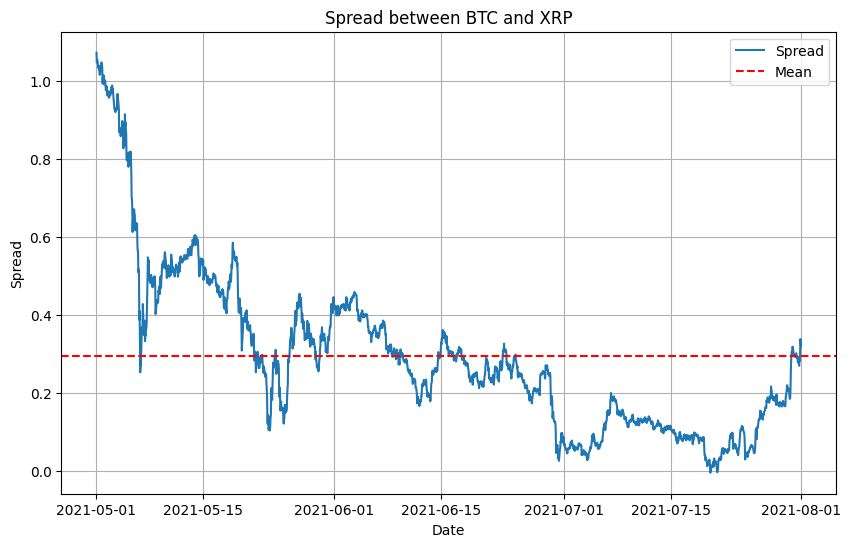

In [30]:
import matplotlib.pyplot as plt

# Plot the spread
plt.figure(figsize=(10, 6))
plt.plot(spread.index, spread.values, label='Spread')
plt.axhline(y=spread.mean(), color='r', linestyle='--', label='Mean')
plt.title('Spread between BTC and XRP')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Initialize the Kalman filter with initial parameter estimates
initial_mean = spread.mean()
initial_variance = spread.var()
initial_covariance = np.cov(spread.values, rowvar=False)
transition_matrix = [1]
observation_matrix = [1]
initial_state_mean = [initial_mean]
initial_state_covariance = [[initial_variance]]

# Create the Kalman filter
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance
)

# Estimate the spread parameters using the Kalman filter
filtered_state_means, filtered_state_covariances = kf.filter(spread.values)

In [41]:
# Apply the Kalman filter to track and update the spread estimate
filtered_spread = np.squeeze(filtered_state_means)
predicted_spread = filtered_spread[:-1]  # Predicted spread (t-1)
observed_spread = [spread.values[-1]]     # Observed spread (t)

# Update the Kalman filter's estimates
updated_state_means, updated_state_covariances = kf.filter_update(
    filtered_state_mean=filtered_state_means[-1],
    filtered_state_covariance=filtered_state_covariances[-1],
    observation=observed_spread
)

# Access the updated spread estimate
updated_spread = np.squeeze(updated_state_means)

# Example: Print the estimated spread at the latest observation
latest_estimated_spread = updated_spread[-1]
print("Latest Estimated Spread:", latest_estimated_spread)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [43]:
updated_state_means

masked_array(data=[0.32092388],
             mask=False,
       fill_value=1e+20)

In [39]:
filtered_spread[:-1]

array([0.32678768, 0.69448615, 0.90983308, ..., 0.29319863, 0.32108005,
       0.32549394])